In [1]:
import torch 
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Q = torch.tensor([[2.0, 1.0],
                  [1.0, 1.0]])

def f(x):
    return torch.einsum("...i,ij,...j", x, Q, x)

def fa(x, x_k):
    dx = x-x_k
    grad = 2 * torch.einsum("ij,...j", Q, x_k)
    return f(x_k) +  torch.einsum("...i, ...i", grad, dx)

s = 3.0
x1 = torch.linspace(-s, s, 100)
x2 = torch.linspace(-s, s, 100)
x = torch.stack(torch.meshgrid(x1, x2, indexing="xy"), dim=2)

x_0 = torch.tensor([0.5, 0.5])
x01 = torch.linspace(0.0, 1.0, 100)
x02 = torch.linspace(0.0, 1.0, 100)
x0 = torch.stack(torch.meshgrid(x01, x02, indexing="xy"), dim=2)

print(f(x_0))


fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "surface"}]])
fig.add_trace(go.Contour(z=f(x), x=x1, y=x2, ncontours=25, opacity=0.75,zmin=0, zmax=54), row=1, col=1)
fig.add_trace(go.Contour(z=fa(x0, x_0), x=x01, y=x02, ncontours=25,  zmin=0, zmax=54), row=1, col=1)
fig.add_trace(go.Surface(z=f(x), x=x[...,0], y=x[...,1], opacity=0.75,  cmin=0, cmax=54), row=1, col=2)
fig.add_trace(go.Surface(z=fa(x0, x_0), x=x0[...,0], y=x0[...,1], cmin=0, cmax=54), row=1, col=2)
fig.update_traces(showscale=False)
fig.update_layout(autosize=False, width=1000, height=500)
fig.show()

tensor(1.2500)


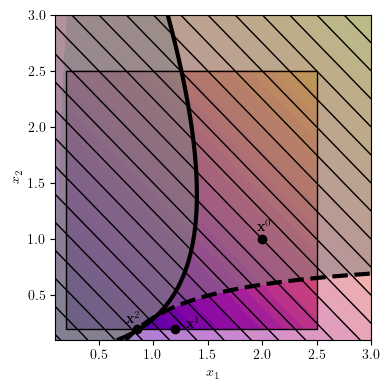

In [75]:
import torch 
import matplotlib.pyplot as plt 
import matplotlib.patches as patches

plt.rcParams['text.usetex'] = True
torch.set_default_dtype(torch.double)

def f(x):
    return x[...,0] + x[...,1]

def g(x):
    return 8/(16*x[...,0] + 9*x[...,1]) - 4.5/(9*x[...,0] + 16*x[...,1]) -0.1

def CONLIN(func, x_k, x):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin).sum(), x_lin)[0]
    res = func(x_k)*torch.ones_like(x[...,0])
    for i, grad in enumerate(grads):
        if grad < 0:
            gamma = x_k[i]/x[...,i]
        else:
            gamma = 1
        res += grad * gamma * (x[...,i]-x_k[i])
    return res


xx = torch.linspace(0.1, 3.0, 100)
x = torch.stack(torch.meshgrid(xx, xx, indexing="xy"), dim=2)
xxv = torch.linspace(0.2, 2.5, 100)
xv = torch.stack(torch.meshgrid(xxv, xxv, indexing="xy"), dim=2)

x_0 = torch.tensor([2.0, 1.0])
x_1 = torch.tensor([1.2, 0.2])
x_2 = torch.tensor([0.85, 0.2])
g_0 = CONLIN(g, x_0, x)
g_1 = CONLIN(g, x_1, x)

with torch.no_grad():
    fig = plt.figure(figsize=(4,4))
    plt.contour(xx,xx,f(x), levels=25, colors="k", linewidths=1)
    plt.contourf(xx,xx,f(x), levels=25, cmap="plasma", alpha=0.5)
    plt.contourf(xxv,xxv,f(xv), levels=25, cmap="plasma", vmin=f(x).min(), vmax=f(x).max())
    rect = patches.Rectangle((0.2, 0.2), 2.3, 2.3, edgecolor="k", facecolor="none", zorder=2)
    plt.gca().add_patch(rect)
    plt.contour(xx, xx, g(x), [0], colors="k", linewidths=3)
    plt.contourf(xx, xx, g(x), [0,1], colors="gray", alpha=0.5)
    plt.contour(xx, xx, g_1, [0], colors="k", linewidths=3, linestyles="--")
    plt.contourf(xx, xx, g_1, [0,1], colors="gray", alpha=0.5)
    plt.plot([x_0[0]],[x_0[1]], "o", color="black")
    plt.annotate("$\mathbf{x}^0$", (1.95, 1.07), color="black")
    plt.plot([x_1[0]],[x_1[1]], "o", color="black")
    plt.annotate("$\mathbf{x}^1$", (1.3, 0.21), color="black")
    plt.plot([x_2[0]],[x_2[1]], "o", color="black")
    plt.annotate("$\mathbf{x}^2$", (0.75, 0.25), color="black")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.tight_layout()
    plt.savefig("figures/four_bar_example_1.pdf", transparent=True)
    plt.plot()

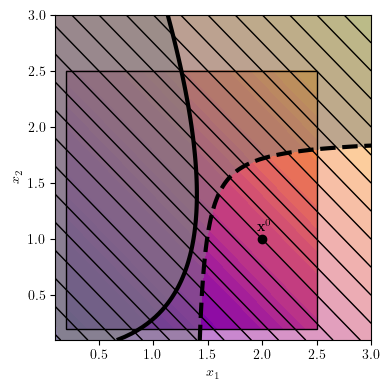

In [94]:
def MMA(func, x_k, l_k, u_k, x):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin).sum(), x_lin)[0]
    res = func(x_k)*torch.ones_like(x[...,0])
    for i, grad in enumerate(grads):
        if grad < 0:
            gamma = (x_k[i]-l_k[i])/(x[...,i]-l_k[i])
        else:
            gamma = (u_k[i]-x_k[i])/(u_k[i]-x[...,i])
        res += grad * gamma * (x[...,i]-x_k[i])
    return res

xx = torch.linspace(0.1, 3.0, 100)
x = torch.stack(torch.meshgrid(xx, xx, indexing="xy"), dim=2)

x_0 = torch.tensor([2.0, 1.0])
x_min = torch.tensor([0.2, 0.2])
x_max = torch.tensor([2.5, 2.5])
l_0 = x_0 - 0.5 * (x_max-x_min)
u_0 = x_0 + 0.5 * (x_max-x_min)
g_0 = MMA(g, x_0, l_0, u_0, x) 
g_0[x[...,0]<l_0[0]] = 1.0
g_0[x[...,1]>u_0[1]] = 1.0

with torch.no_grad():
    fig = plt.figure(figsize=(4,4))
    plt.contour(xx,xx,f(x), levels=25, colors="k", linewidths=1)
    plt.contourf(xx,xx,f(x), levels=25, cmap="plasma", alpha=0.5)
    plt.contourf(xxv,xxv,f(xv), levels=25, cmap="plasma", vmin=f(x).min(), vmax=f(x).max())
    rect = patches.Rectangle((0.2, 0.2), 2.3, 2.3, edgecolor="k", facecolor="none", zorder=2)
    plt.gca().add_patch(rect)
    plt.contour(xx, xx, g(x), [0], colors="k", linewidths=3)
    plt.contourf(xx, xx, g(x), [0,1], colors="gray", alpha=0.5)
    plt.contour(xx, xx, g_0, [0], colors="k", linewidths=3, linestyles="--")
    plt.contourf(xx, xx, g_0, [0,10], colors="gray", alpha=0.5)
    plt.plot([x_0[0]],[x_0[1]], "o", color="black")
    plt.annotate("$\mathbf{x}^0$", (1.95, 1.07), color="black")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.tight_layout()
    plt.savefig("figures/four_bar_example_mma_1.pdf", transparent=True)
    plt.plot()